In [1]:
import numpy as np
import cv2
import glob
import time 
import matplotlib.pyplot as plt 
import pickle
import os

### Reading Training Images

In [2]:
def img_read(dir,image_type):
    """
    
    """
    images=[]
    for dirpath,dirnames,files in os.walk(dir):
        for dirname in dirnames:
            images.append(glob.glob(dir + '/' + dirname + '/' + image_type))
            #flattens a list of list
            flatten = [item for sublist in images for item in sublist]
            
    return list(map(lambda img: cv2.cvtColor(cv2.imread(img),cv2.COLOR_BGR2RGB),flatten))
vehicles = img_read('./training_images/vehicles','*.png')

In [3]:
non_vehicles = img_read('./training_images/non-vehicles','*.png')

In [4]:
print(len(vehicles))
print(len(non_vehicles))

8792
8968


## Visualizing the Data

The number of Vehicle images for training is :8792
THe number of Non-vehicle images for training is :8968


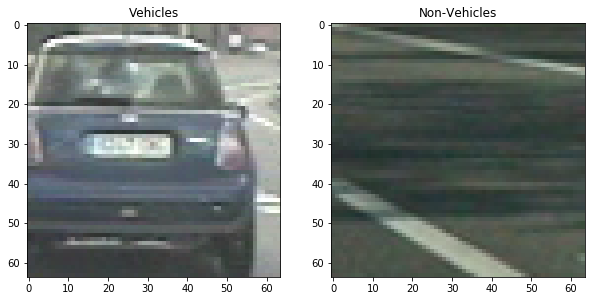

In [5]:
fig,axs = plt.subplots(ncols = 2,figsize=(10,10))
axs[0].imshow(vehicles[0]) 
axs[0].set_title('Vehicles')
axs[1].imshow(non_vehicles[0])
axs[1].set_title('Non-Vehicles')

print('The number of Vehicle images for training is :{}' .format(len(vehicles)))
print('THe number of Non-vehicle images for training is :{}'.format(len(non_vehicles)))

In [6]:
im1 = vehicles[0]
print(im1.shape)

(64, 64, 3)


# Feature Extraction 

In [7]:
def bin_spatial(img,size=(32,32)):
    img = cv2.resize(img,size).ravel()
    return img

def color_hist(img, nbins=32, bins_range=(0,256)):
    
    channel1_hist = np.histogram(img[:,:,0],nbins ,bins_range)
    channel2_hist = np.histogram(img[:,:,1],nbins ,bins_range)
    channel3_hist = np.histogram(img[:,:,2],nbins ,bins_range)

    hist_features = np.concatenate((channel1_hist[0],channel2_hist[0],channel3_hist[0]))
    
    return hist_features

from skimage.feature import hog

def get_hog_features(img,orient,pix_per_cell,cell_per_block,vis=False,feature_vec=True):
    
    if vis == True:
        features,hog_image = hog(img, orient, pixels_per_cell=(pix_per_cell,pix_per_cell),cells_per_block=(cell_per_block,cell_per_block),visualise=vis,feature_vector=feature_vec)  
        return features, hog_image
    else:
        
        features = hog(img, orient, pixels_per_cell=(pix_per_cell,pix_per_cell),cells_per_block=(cell_per_block,cell_per_block),visualise=vis,feature_vector=feature_vec)
    
        return features

    
class FeaturesParameters():
    def __init__(self):
        
        self.cspace = 'YCrCb'
        # HOG parameters
        self.pix_per_cell = 8
        self.orient = 8
        self.cell_per_block = 2
        self.hog_channel = 'ALL'
        # Bin spatial parameters
        self.size = (16,16)
        # Histogram parameters
        self.hist_bins = 32
        self.hist_range = (0,256)
        
def extract_features(img , params):
    
    cspace = params.cspace 
    
    #HOG parameters
    pixel_per_cell = params.pix_per_cell
    orient = params.orient
    cell_per_block = params.cell_per_block
    hog_channel = params.hog_channel
    
    #Bin spatial parameters 
    size = params.size
    
    #Histogram parameters
    hist_bins = params.hist_bins
    hist_range = params.hist_range
    
    # COLOR Convertion
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_img = cv2.cvtColor(img,cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_img = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_img = cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)
    else:
        feature_img = np.copy(img)
    
    if hog_channel == 'ALL':
        hog_features=[]
        for channel in range(feature_img.shape[2]):
            hog_features.append(get_hog_features(feature_img,orient,
                                                 pixel_per_cell,
                                                 cell_per_block,
                                                 vis=False,feature_vec=True))
        hog_features = np.ravel(hog_features)
    
    else:
        hog_features = get_hog_features(feature_img[:,:,hog_channel],orient,
                                        pixel_per_cell,
                                        cell_per_block,
                                        vis=False,feature_vec=True)
    spatial_features = bin_spatial(feature_img,size)
    
    histogram_features = color_hist(feature_img,hist_bins,hist_range)
    
    return np.concatenate((spatial_features,histogram_features,hog_features))
        

In [8]:
params = FeaturesParameters()
print(extract_features(im1,params).shape)

(5568,)


/home/akg/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
/home/akg/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def model_fit(Vehicle_feat,Non_Vehicle_feat,SVC,scalar,params):
    
    Vehicle_features = list(map(lambda img: extract_features(img,params),Vehicle_feat))    
    Non_Vehicle_features = list(map(lambda img: extract_features(img,params),Non_Vehicle_feat))
    
    # Stacking and scaling 
    X = np.vstack((Vehicle_features,Non_Vehicle_features)).astype(np.float64)
    print(X.shape)
    X_scaler = scalar.fit(X)
    scaled_X = X_scaler.transform(X)
    
    y = np.hstack((np.ones(len(Vehicle_features)),np.zeros(len(Non_Vehicle_features))))
    print(len(y))
    #Split up the data into randomized training and testing sets
    rand_state = np.random.randint(0,100)
    X_train,X_test,y_train,y_test = train_test_split(scaled_X,y,test_size = 0.2,random_state = rand_state)
    
    #Fitting 
    t1  = time.time()
    SVC.fit(X_train,y_train)
    t2 = time.time()
    
    fitting_time = round(t2-t1,2)
    accuracy = round(SVC.score(X_test, y_test),4)
    
    return (SVC,scalar,fitting_time,accuracy)
    

/home/akg/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [10]:
from sklearn.svm import LinearSVC

In [11]:
params = FeaturesParameters()
svc,scalar,fittingTime,accuracy = model_fit(vehicles,non_vehicles,LinearSVC(),StandardScaler(),params)
print('Fitting time: {} s, Accuracy: {}'.format(fittingTime, accuracy))

/home/akg/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
/home/akg/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


(17760, 5568)
17760
Fitting time: 12.62 s, Accuracy: 0.9854


/home/akg/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


# Showing hog Images from training 

/home/akg/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
/home/akg/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


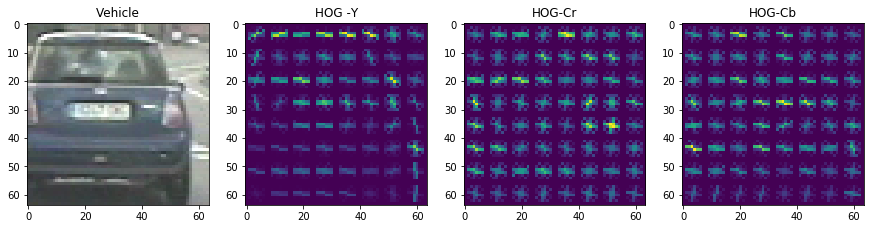

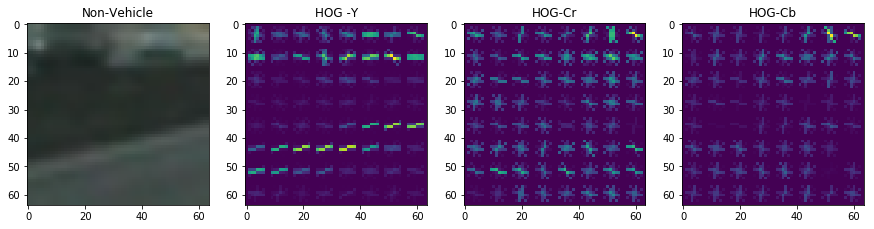

In [12]:
def showHog(image,title):
    
    img_cspaced = cv2.cvtColor(image,cv2.COLOR_RGB2YCrCb)
    
    _,hog_image_Y = get_hog_features(img_cspaced[:,:,0],
                                     params.orient,params.pix_per_cell,
                                     params.cell_per_block,
                                     vis=True,feature_vec=True)
    
    _,hog_image_Cr = get_hog_features(img_cspaced[:,:,1],
                                      params.orient,params.pix_per_cell,
                                      params.cell_per_block,
                                      vis=True,feature_vec=True)
    
    _,hog_image_Cb = get_hog_features(img_cspaced[:,:,2],
                                      params.orient,params.pix_per_cell,
                                      params.cell_per_block,
                                      vis=True,feature_vec=True)

    fig,axs = plt.subplots(ncols=4,figsize=(15,15))
    axs[0].imshow(image)                                  
    axs[0].set_title(title)
    axs[1].imshow(hog_image_Y)                                  
    axs[1].set_title('HOG -Y')
    axs[2].imshow(hog_image_Cr)                                  
    axs[2].set_title('HOG-Cr')
    axs[3].imshow(hog_image_Cb)
    axs[3].set_title('HOG-Cb')
    
    return
                                     
showHog(vehicles[0],'Vehicle')                                      
showHog(non_vehicles[1],'Non-Vehicle')                                      
                           

In [27]:
def draw_boxes(img, bboxes,color=(0,0,255),thick=1):
    img_draw = np.copy(img)
    for box in bboxes:
        img_draw = cv2.rectangle(img_draw,box[0],box[1],color,thick)
    return img_draw

In [39]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64,64), xy_overlap=(0.5, 0.5)):
    
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    
    # Initialize a list to append window positions to
    window_list = []
    
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            start_x = xs * nx_pix_per_step + x_start_stop[0]
            stop_x = start_x + xy_window[0] 
            start_y = ys* ny_pix_per_step + y_start_stop[0]
            stop_y = start_y + xy_window[1]
            
            window_list.append(((start_x,start_y),(stop_x,stop_y)))
    return window_list

In [40]:
im3 = cv2.imread('/home/akg/Desktop/SVM_yolo/test_images/test1.jpg')
im3.shape

(720, 1280, 3)

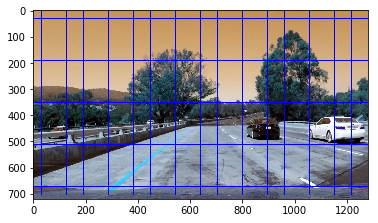

In [41]:
wind = slide_window(im3)
plt.imshow(draw_boxes(im3,wind))

In [44]:
test_images = list(map(lambda img:cv2.cvtColor(cv2.imread(img),cv2.COLOR_BGR2RGB),glob.glob('./test_images/*.jpg')))

['./test_images/test6.jpg', './test_images/test5.jpg', './test_images/test2.jpg', './test_images/test3.jpg', './test_images/test4.jpg', './test_images/test1.jpg']
